In [1]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import os

from matplotlib import pyplot as plt
from dotenv import load_dotenv

load_dotenv()
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100

warnings.filterwarnings("ignore")


# Feature engineering :

Les resultats des regressions linéaires (OLS, LASSO, Ridge, ENET) se sont montrés assez decevants : le score R2 depasse rarement 0.6. <br>
Certaines features peuvent eventuellement être retouchées pour augmenter la precision de la modelisation. <br>

- Les données lineaires continues ont déjà été standardisées et scalées. Analyse de la distribution pour potentiel passage au Log.
- Conversion de "Year Built" vers "Building Age", cela devrait reduire le poids de cette variable qui ne semblait pas avoir beaucoup d'influence sur les emissions de GES ou la consommation electrique durant l'analyse.
- Ajout d'une nouvelle metrique booleene : Is_Energy_Star_Certified (E* >= 75). Verifications des possibilités de predire non pas la note mais la certification ou non d'un batiment. Si les resultats de cette modelisation (nb_xy_estar.ipynb) sont satisfaisant, cela peut etre une alternative a l'elimination totale de cette variable au profit d'un calcul plus simple.
- Application de ces parametres sur le dataset commun et sur les donnees deja reparties (test/train) sur les GES

In [2]:
file_train, file_test = "./data/train_set_70percent_ghg.csv", "./data/test_set_30percent_ghg.csv"
common_file = "./data/seattle_predict_ghg_eui.csv"


In [3]:
df_ghg_eui = pd.read_csv(common_file)
df_ghg_eui.set_index("OSEBuildingID", inplace=True)


In [4]:
df_ghg_eui.columns

Index(['scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)',
       'scaled_PropertyArea(SquareMetre)Total', 'scaled_SourceEUI(kWh/m2)',
       'scaled_NaturalGas(kWh)', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Building_proportion',
       'Parking_proportion', 'target_SourceEUI(kWh/m2)',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'ohe_nbhood_BALLARD',
       'ohe_nbhood_CENTRAL', 'ohe_nbhood_DELRIDGE', 'ohe_nbhood_DOWNTOWN',
       'ohe_nbhood_EAST', 'ohe_nbhood_GREATER DUWAMISH',
       'ohe_nbhood_LAKE UNION', 'ohe_nbhood_MAGNOLIA / QUEEN ANNE',
       'ohe_nbhood_NORTH', 'ohe_nbhood_NORTHEAST', 'ohe_nbhood_NORTHWEST',
       'ohe_nbhood_SOUTHEAST', 'ohe_nbhood_SOUTHWEST', 'ohe_ptype_Hospital',
       'ohe_ptype_Hotel', 'ohe_ptype_K-12 School', 'ohe_ptype_Large Office',
       'ohe_ptype_Mixed Use Property', 'ohe_ptype_Office', 'ohe_ptype_Other',
       'ohe_ptype_Refrigerated Warehouse', 'ohe_ptype_Residence Hall',
    

- Le prefixe OHE, One Hot Encoded, n'est pas a modifier.
- Les features categorielles continues : NumberofBuildings, NumberofFloors sont ingorées.
- Les features target sont exclues des matrices de modelisation, il est inutile de les modifier
- L'etude se porte sur : <br>
 `'scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)' 'scaled_PropertyArea(SquareMetre)Total' 'scaled_SourceEUI(kWh/m2)', 'scaled_NaturalGas(kWh)', 'YearBuilt', 'ENERGYSTARScore',`

## 1 : Changement de la variable "YearBuilt" vers "BuildingAge"

In [5]:
df_ghg_eui["BuildingAge"] = np.nan
for index, row in df_ghg_eui.iterrows():
    df_ghg_eui.loc[index, "BuildingAge"] = int(2022 - row["YearBuilt"])

df_ghg_eui.drop(columns=["YearBuilt"], inplace=True)


## 2 : Ajout d'une nouvelle variable : Energy Star Certified

In [6]:
df_ghg_eui["EnergyStarCert"] = 0
for index, row in df_ghg_eui.iterrows():
    if row["ENERGYSTARScore"] >= 75:
        df_ghg_eui.loc[index, "EnergyStarCert"] = 1


## 3 : Verification des variables lineaires continues pour eventuel passage au log

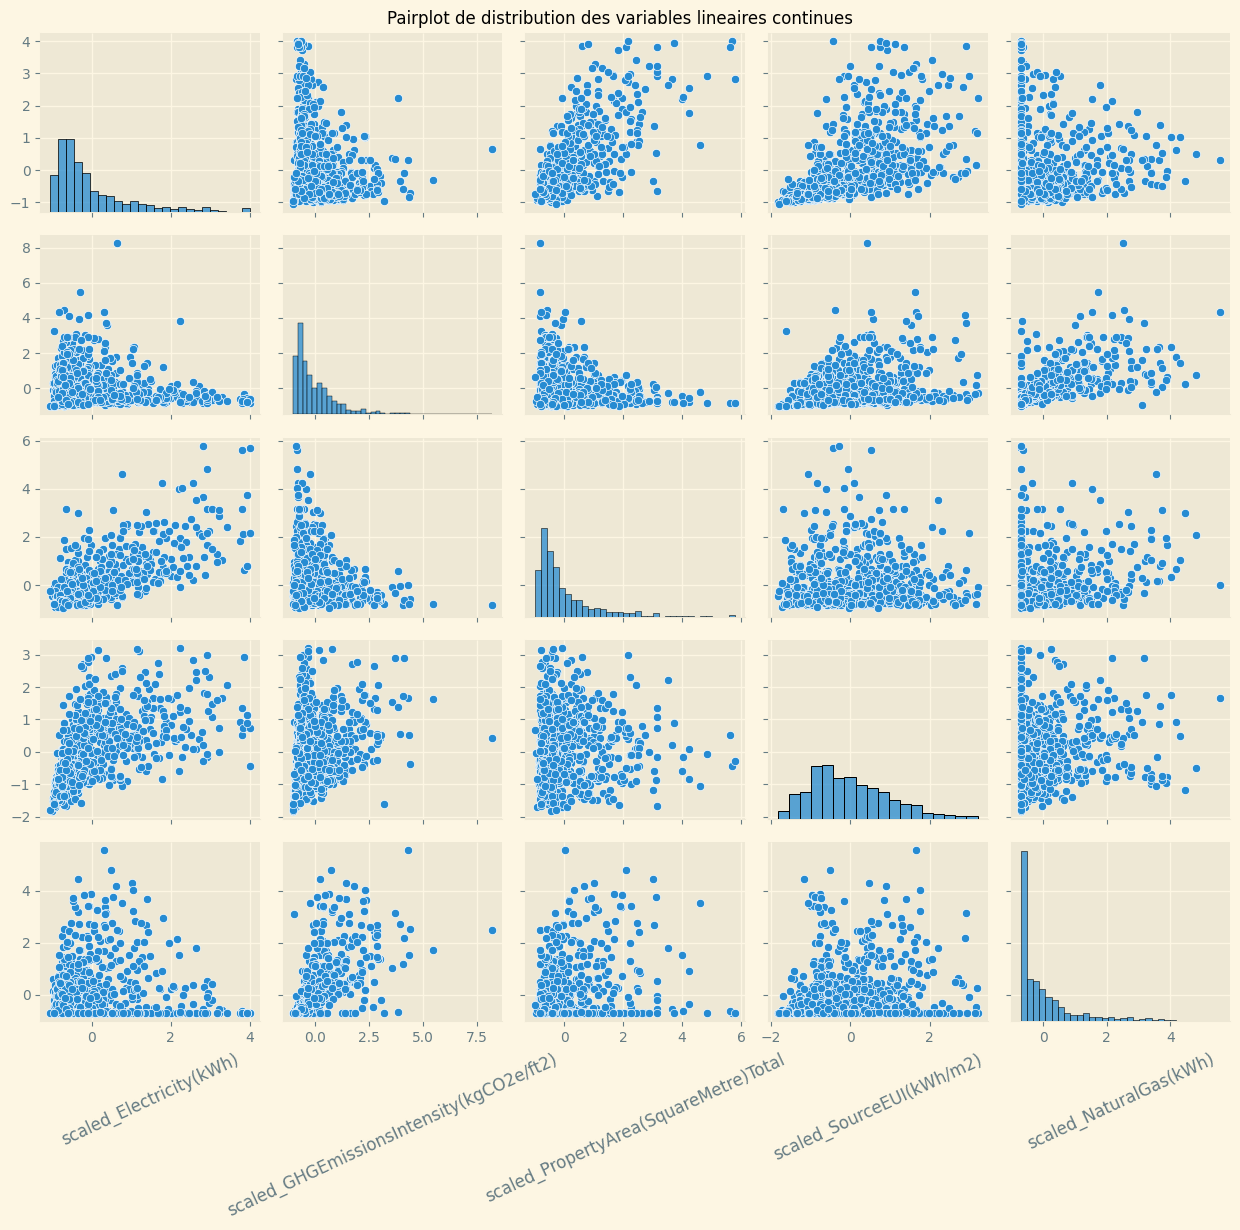

In [7]:
col_subset = [
    "scaled_Electricity(kWh)", "scaled_GHGEmissionsIntensity(kgCO2e/ft2)", 
    "scaled_PropertyArea(SquareMetre)Total", "scaled_SourceEUI(kWh/m2)", 
    "scaled_NaturalGas(kWh)"
    ]

pairplot = sns.pairplot(
    data=df_ghg_eui[col_subset]
)

pairplot.figure.set_dpi(100)

###
# Titles/Lables
for axes in pairplot.axes.flat:
    axes.set_ylabel("")
    axes.set_xlabel(axes.get_xlabel(), rotation=25)
pairplot.figure.suptitle("Pairplot de distribution des variables lineaires continues")
#
###

plt.tight_layout()
plt.show()


#### Observations :

- On peut voir que des variables comme scaled_NaturalGas et scaled_ghgemissionIntensity ne sont pas normalement distribuées. SourceEUI semble etre plus normalement distribué.
- On peut passer toutes les donnees au log pour voir si les changements sont significatifs (sauf source EUI)


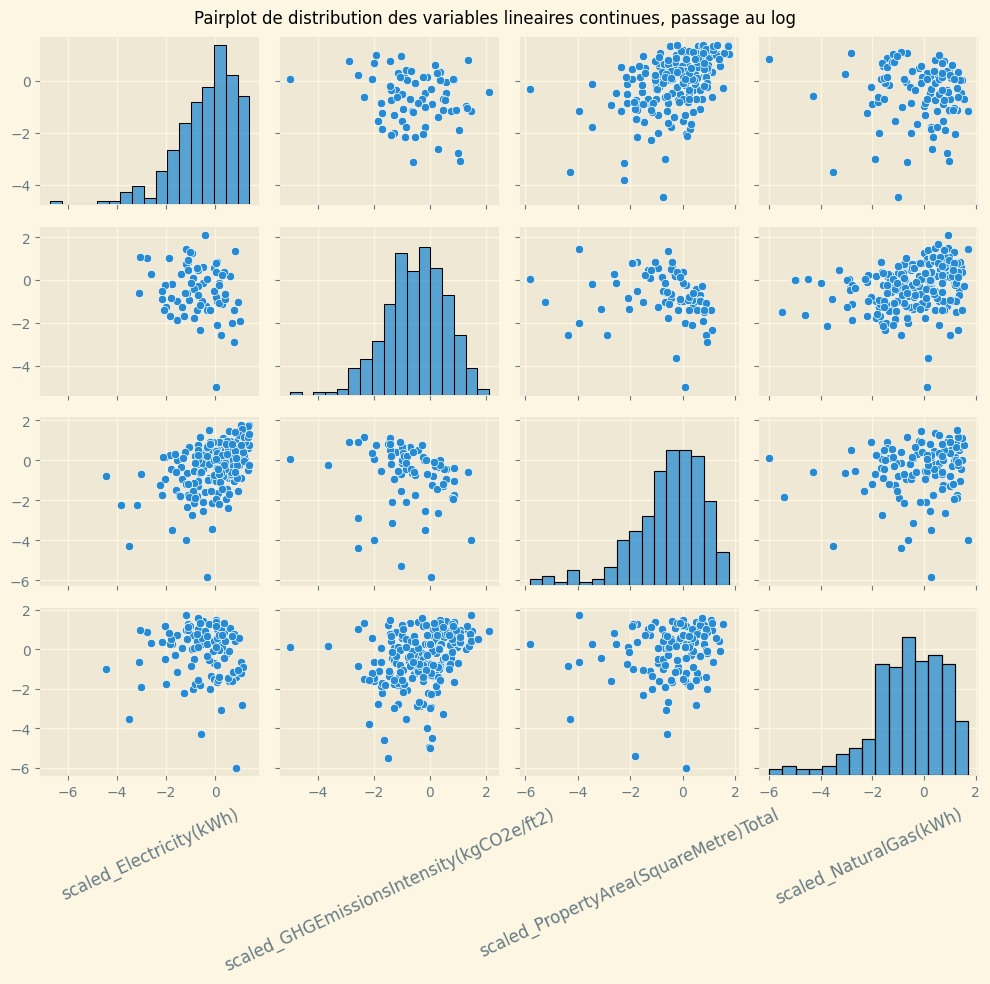

In [8]:
col_subset = [
    "scaled_Electricity(kWh)", "scaled_GHGEmissionsIntensity(kgCO2e/ft2)", 
    "scaled_PropertyArea(SquareMetre)Total", "scaled_NaturalGas(kWh)"
    ]

log_data = df_ghg_eui[col_subset]

for column in log_data.columns:
    log_data[column] = np.log(log_data[column])

pairplot = sns.pairplot(
    data=log_data
)

pairplot.figure.set_dpi(100)
###
# Titles/Lables
for axes in pairplot.axes.flat:
    axes.set_ylabel("")
    axes.set_xlabel(axes.get_xlabel(), rotation=25)
pairplot.figure.suptitle("Pairplot de distribution des variables lineaires continues, passage au log")
#
###
plt.tight_layout()
plt.show()


#### Observations : 
- GHG Emissions est bien mieux distribué de en utilisant log(data)
- La distribution de Natural Gas semble etre trop impactée, comme Electricity, meme si, dans le cas de natural_gas, une amelioration est visible
- Electricity semble avoir une distribution totalement inverse

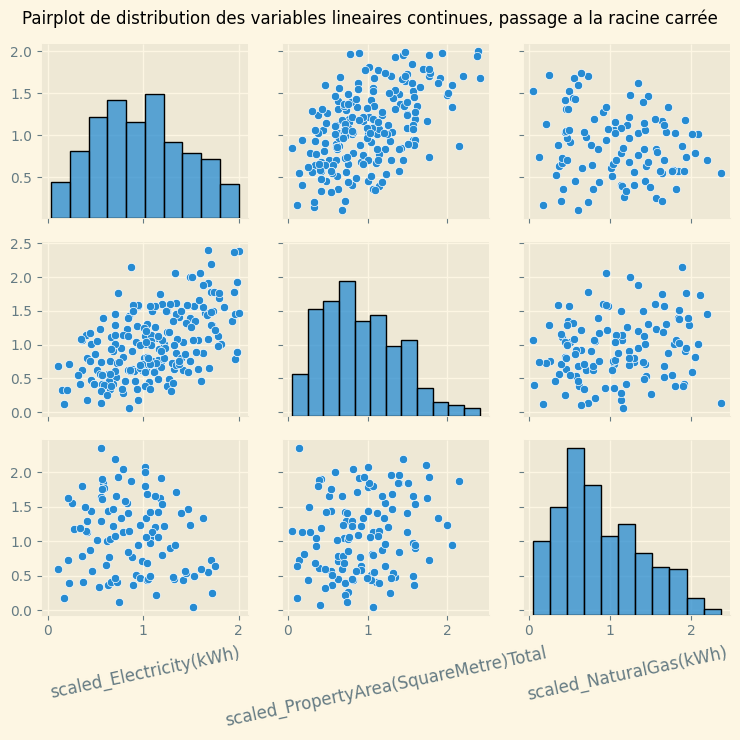

In [9]:
col_subset = [
    "scaled_Electricity(kWh)", "scaled_PropertyArea(SquareMetre)Total", "scaled_NaturalGas(kWh)"
    ]

sqrt_data = df_ghg_eui[col_subset]

for column in sqrt_data.columns:
    sqrt_data[column] = np.sqrt(sqrt_data[column])

pairplot = sns.pairplot(
    data=sqrt_data
)

pairplot.figure.set_dpi(100)
###
# Titles/Lables
for axes in pairplot.axes.flat:
    axes.set_ylabel("")
    axes.set_xlabel(axes.get_xlabel(), rotation=12)
pairplot.figure.suptitle("Pairplot de distribution des variables lineaires continues, passage a la racine carrée")
#
###
plt.tight_layout()
plt.show()


#### Observations :

- Le passage a la racine carée est globalement preferable dans le cas de l'electricité et de l'utilisation de gazs naturels

# Conclusions : 

- Les données anormalement distribuées ("Electricity(kWh)", "GHGEmissionsIntensity(kgCO2e/ft2)", "PropertyArea(SquareMetre)Total", "NaturalGas(kWh)") beneficient
    - d'un passage au log pour : GHGEmissions, possiblement PropertyArea
    - d'une reduction a la racine carrée pour : Electricity, Natural Gas, possiblement Property Area

- Les données seront ajustées en suivant ces parametres, ainsi que les nouvelles variables.
